In [27]:
import numpy as np
import keras
import random
import pathlib
import cv2
import os
from keras.models import Sequential,load_model, save_model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import pickle
from keras.applications.nasnet import NASNetLarge
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

In [28]:
EPOCHS = 50
INIT_LR = 1e-3
BATCH_SIZE = 32
width =331
height =331
image_size = (width, height)
depth=3
root_dir = r'E:\dog\imagesx331'
data_root = pathlib.Path(root_dir)
print(data_root)


E:\dog\imagesx331


In [29]:
random.seed(32)
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)
image_count = len(all_image_paths)
image_count

20580

In [30]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
no_class=len(label_names)
print(label_names)
print(no_class)

['Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'French_bulldog', 'German_shepherd', 'German_short-haired_pointer', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Kerry_blue_terrier', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', 'Maltese_dog', 'Mexican_hairless', 'Newfoundland', 'Norfolk_terrier', 'Norwegian_elkhound', 'Norwich_terrier', 'Old_English_sheepdog', 'Pekinese', 'Pembroke', 'Po

In [31]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
print(label_to_index)

index_to_label = dict((index, name) for index, name in enumerate(label_names))
print(index_to_label)

all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

{'Afghan_hound': 0, 'African_hunting_dog': 1, 'Airedale': 2, 'American_Staffordshire_terrier': 3, 'Appenzeller': 4, 'Australian_terrier': 5, 'Bedlington_terrier': 6, 'Bernese_mountain_dog': 7, 'Blenheim_spaniel': 8, 'Border_collie': 9, 'Border_terrier': 10, 'Boston_bull': 11, 'Bouvier_des_Flandres': 12, 'Brabancon_griffon': 13, 'Brittany_spaniel': 14, 'Cardigan': 15, 'Chesapeake_Bay_retriever': 16, 'Chihuahua': 17, 'Dandie_Dinmont': 18, 'Doberman': 19, 'English_foxhound': 20, 'English_setter': 21, 'English_springer': 22, 'EntleBucher': 23, 'Eskimo_dog': 24, 'French_bulldog': 25, 'German_shepherd': 26, 'German_short-haired_pointer': 27, 'Gordon_setter': 28, 'Great_Dane': 29, 'Great_Pyrenees': 30, 'Greater_Swiss_Mountain_dog': 31, 'Ibizan_hound': 32, 'Irish_setter': 33, 'Irish_terrier': 34, 'Irish_water_spaniel': 35, 'Irish_wolfhound': 36, 'Italian_greyhound': 37, 'Japanese_spaniel': 38, 'Kerry_blue_terrier': 39, 'Labrador_retriever': 40, 'Lakeland_terrier': 41, 'Leonberg': 42, 'Lhasa': 

In [32]:
with open("idx2label.pkl", "wb") as f:
  pickle.dump(index_to_label, f)

In [33]:
train_imgs = []
train_labels = []
val_imgs = []
val_labels = []
test_imgs = []
test_labels = []
split_point_1=0.8
split_point_2=1.0
for label_name in os.listdir(root_dir):
    label_dir = os.path.join(root_dir, label_name)
    images_list = [os.path.join(label_dir, x) for x in os.listdir(label_dir)]
    
    random.shuffle(images_list)
    l = len(images_list)
    train_imgs += images_list[:int(l * split_point_1)]
    train_labels += [label_to_index[label_name]] * int(l * split_point_1)
    
    val_imgs += images_list[int(l * split_point_1) : int(l * split_point_2)]
    val_labels += [label_to_index[label_name]] * (int(l * split_point_2) - int(l * split_point_1))
    if split_point_2<1.0:
        test_imgs += images_list[int(l * split_point_2):]
        test_labels += [label_to_index[label_name]] * (l - int(l * split_point_2))
if split_point_2>=1.0:
    test_imgs=val_imgs.copy()
    test_labels=val_labels.copy()
assert len(train_imgs) == len(train_labels)
assert len(val_imgs) == len(val_labels)
assert len(test_imgs) == len(test_labels)

In [34]:
print(train_imgs[:5], train_labels[:5])

['E:\\dog\\imagesx331\\affenpinscher\\n02110627_641.jpg', 'E:\\dog\\imagesx331\\affenpinscher\\n02110627_6414.jpg', 'E:\\dog\\imagesx331\\affenpinscher\\n02110627_10439.jpg', 'E:\\dog\\imagesx331\\affenpinscher\\n02110627_8695.jpg', 'E:\\dog\\imagesx331\\affenpinscher\\n02110627_2383.jpg'] [74, 74, 74, 74, 74]


In [35]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, image_paths, labels, batch_size=BATCH_SIZE, dim=(width, height), n_channels=3,
                 n_classes=no_class, transformer=None, shuffle=True, is_train=False):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.image_paths = image_paths
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.transformer = transformer
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
#         list_IDs_temp = [self.image_paths[k] for k in indexes]
        list_IDs_temp = indexes

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = cv2.imread(self.image_paths[ID])
            img = img[...,::-1] # BGR to RGB
#             img = Image.fromarray(img)
            if self.transformer:
                img = self.transformer(img)
            X[i,] = img

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [36]:
class TransformerCompose():
  def __init__(self, list_trans):
    self.list_trans = list_trans
    
  def __call__(self, img):
    for trans in self.list_trans:
      img = trans(img)
    return img
  
class ScaleImage():
  def __init__(self):
    pass
  
  def __call__(self, img):
    return img / 255.0

class ResizeImage():
  def __init__(self, size=(width, height)):
    self.size = size
  
  def __call__(self, img):
    img = cv2.resize(img, self.size, interpolation=cv2.INTER_NEAREST)
    return img

class RandomHorizontalFlip():
  def __init__(self, p=0.5):
    self.p = p
    
  def __call__(self, img):
    if random.random() < self.p:
      img = np.fliplr(img)
    return img

class RandomRotation():
  def __init__(self, angle=25):
    self.angle = angle
  
  def __call__(self, img):
    angle = random.random() * self.angle
    rows,cols,_ = img.shape

    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    return dst
  
class RandomShift():
  def __init__(self, max_w=0.1, max_h=0.1):
    self.max_w = 0.1
    self.max_h = 0.1
    
  def __call__(self, img):
    h, w, _ = img.shape
    shift_w = int(random.uniform(-self.max_w, self.max_w) * w)
    shift_h = int(random.uniform(-self.max_w, self.max_h) * h)
    
    M = np.float32([[1, 0, shift_w], [0, 1, shift_h]])
    dst = cv2.warpAffine(img, M, (w, h))
    return dst

class RandomShear(object):
    def __init__(self, shear_factor = 0.2):
        self.shear_factor = shear_factor
        
        if type(self.shear_factor) == tuple:
            assert len(self.shear_factor) == 2, "Invalid range for scaling factor"   
        else:
            self.shear_factor = (-self.shear_factor, self.shear_factor)
        
    def __call__(self, img):
        shear_factor = random.uniform(*self.shear_factor)
        h, w, _ = img.shape
    
        if shear_factor < 0:
            img = np.fliplr(img)
    
        M = np.array([[1, abs(shear_factor), 0],[0,1,0]])
        nW =  w + abs(shear_factor * h)
        img = cv2.warpAffine(img, M, (int(nW), h))
    
        if shear_factor < 0:
        	img = np.fliplr(img)
    
        img = cv2.resize(img, (w,h))
    
        return img
  
transformer = TransformerCompose([
    ScaleImage(),
    RandomHorizontalFlip(p=0.5),
    RandomRotation(angle=25),
    RandomShift(max_w=0.1, max_h=0.1),
    RandomShear(shear_factor=0.2)
])

In [37]:
train_gen = DataGenerator(train_imgs, train_labels, batch_size=BATCH_SIZE, dim=image_size,
                         n_channels=3, n_classes=no_class, transformer=transformer, shuffle=True)
val_gen = DataGenerator(val_imgs, val_labels, batch_size=BATCH_SIZE, dim=image_size,
                         n_channels=3, n_classes=no_class, transformer=ScaleImage(), shuffle=True)
test_gen = DataGenerator(test_imgs, test_labels, batch_size=BATCH_SIZE, dim=image_size,
                         n_channels=3, n_classes=no_class, transformer=ScaleImage(), shuffle=False)

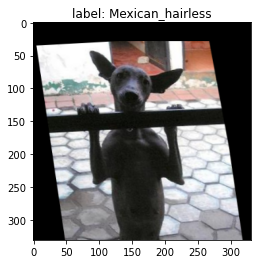

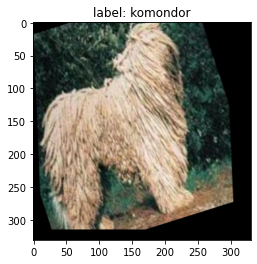

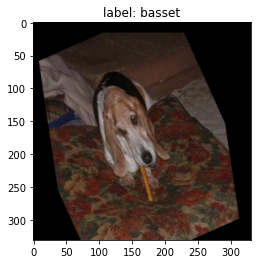

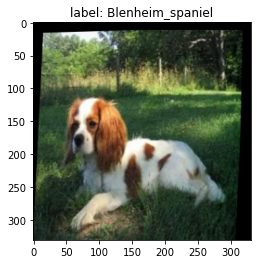

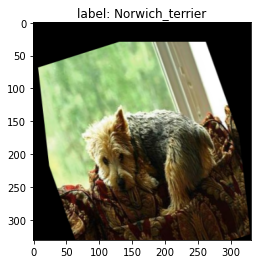

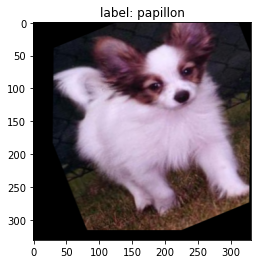

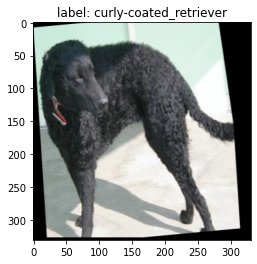

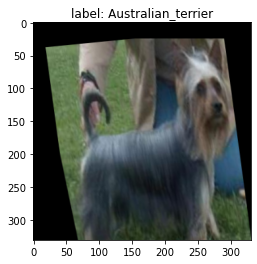

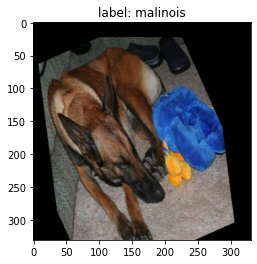

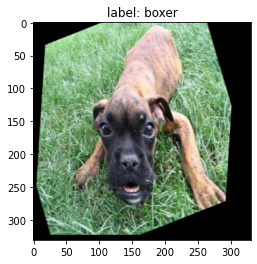

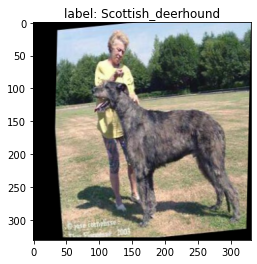

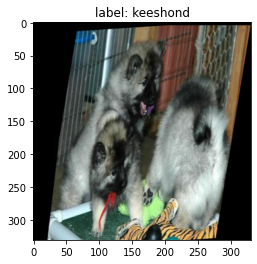

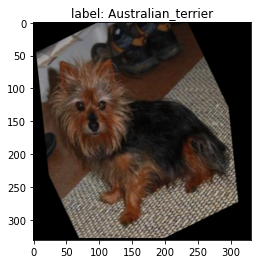

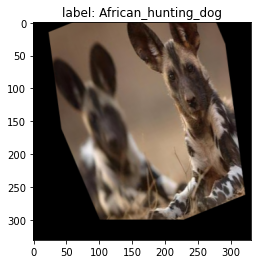

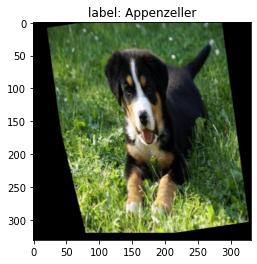

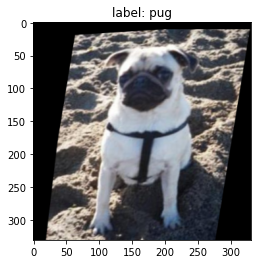

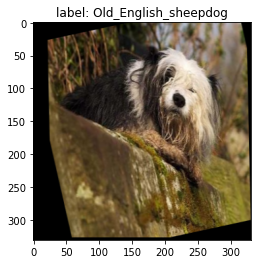

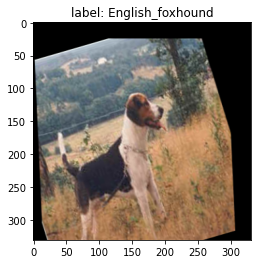

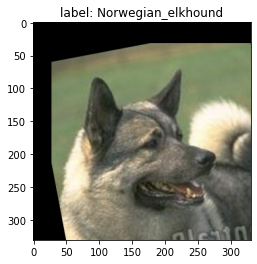

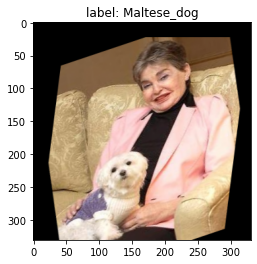

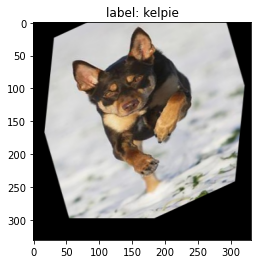

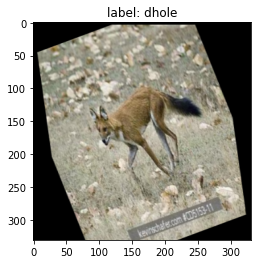

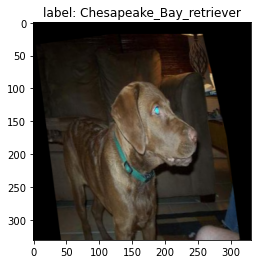

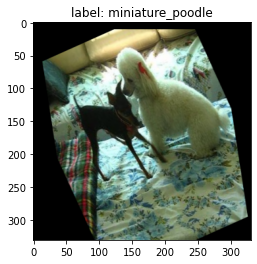

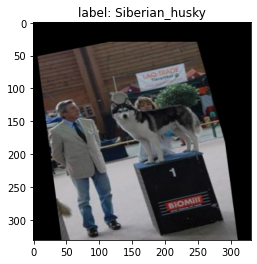

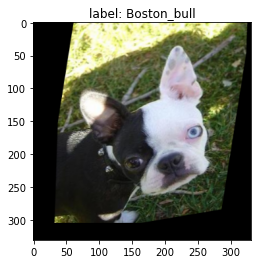

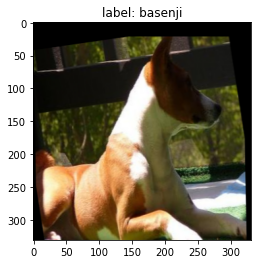

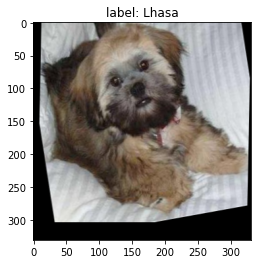

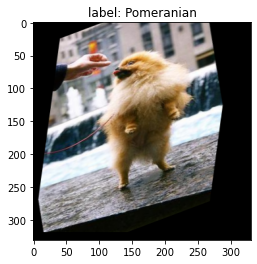

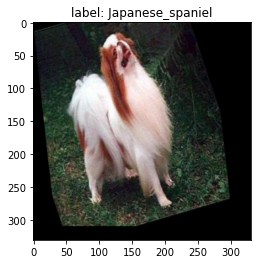

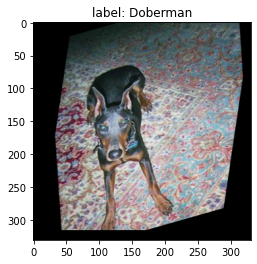

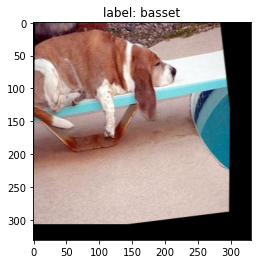

In [38]:
for X, y in train_gen:
    for idx, value in enumerate(X):
        value = value * 255.0
        plt.imshow(value.astype(np.uint8))
        plt.title("label: {}".format(index_to_label[np.argmax(y[idx])]))
        plt.show()
    break


In [40]:
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
    print("Depth first")

In [41]:
nas_model=NASNetLarge(weights='imagenet',include_top=False)

In [42]:
x = nas_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024,activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(no_class, activation = 'softmax')(x)
model = keras.models.Model(inputs = nas_model.input, outputs = x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [43]:
for layer in nas_model.layers:
    layer.trainable = False

In [44]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 331, 331, 3)  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 165, 165, 96) 0           stem_bn1[0][0]                   
____________________________________________________________________________________________

In [45]:
weigh_load="model_ckpt_InceptionResNetV2_dog\\weights.04-05"
if os.path.exists(weigh_load):
    model.load_weights(weigh_load)
    print("Loaded weight")

In [46]:
opt = Adam(lr=INIT_LR, decay = 1e-6)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
print("[INFO] training network...")



[INFO] training network...


In [47]:
path = 'model_ckpt_NASNetLarge_dog'
if not os.path.isdir(path):
    os.mkdir(path)
ckpt_cb = [ModelCheckpoint(os.path.join(path, 'weights.{epoch:02d}-{acc:.3f}-{val_acc:.3f}.hdf5'),
                         save_weights_only=True),
           EarlyStopping(monitor='val_acc', patience=2)
           ]


In [48]:
history = model.fit_generator(
    generator=train_gen,
    steps_per_epoch=len(train_gen),
    validation_data=val_gen,
    validation_steps=len(val_gen),
    epochs=EPOCHS,
    shuffle=False,
    verbose=1,
    callbacks=ckpt_cb,
    use_multiprocessing=False,
    workers=8
    )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
513/513 [==============================] - 2875s 6s/step - loss: 0.9072 - acc: 0.8049 - val_loss: 0.4715 - val_acc: 0.8964

KeyboardInterrupt: 

In [50]:
weigh_load="model_ckpt_InceptionResNetV2_dog\\weights.04-05"
if os.path.exists(weigh_load):
    model.load_weights(weigh_load)
    print("Loaded weight")

In [51]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()


NameError: name 'history' is not defined

In [ ]:
save_model(model,"dog_model_NASNetLarge.h5")

[INFO] Calculating model accuracy


In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate_generator(test_gen, steps=len(test_gen), use_multiprocessing=False, workers=8)
print(f"Test Accuracy: {scores[1]*100}")


In [ ]:
"""
# Use TF to save the graph model instead of Keras save model to load it in Golang
builder = tf.saved_model.builder.SavedModelBuilder("myModel")
# Tag the model, required for Go
builder.add_meta_graph_and_variables(sess, ["myTag"])
builder.save()
sess.close()
"""